In [1]:
import turicreate as tc

# Load image dataset

In [2]:
image_train = tc.SFrame('image_train_data')
image_test = tc.SFrame('image_test_data')

# Task 1: Compute summary statistics of the data

Sketch summaries are techniques for computing summary statistics of data very quickly. In Turi Create has a method sketch which computes summary statistics. Using the training data, compute the sketch summary of the label column and interpret the results by running this command.

`sketch = turicreate.Sketch(image_data['label'])`

Then look at the sketch object to see the summary statistics.

For more information on Sketch, see:

https://apple.github.io/turicreate/docs/api/generated/turicreate.Sketch.html?highlight=sketch

What is the least common category in the training data?

In [3]:
sketch = tc.Sketch(image_train['label'])

In [4]:
sketch


+------------------+-------+----------+
|       item       | value | is exact |
+------------------+-------+----------+
|      Length      |  2005 |   Yes    |
| # Missing Values |   0   |   Yes    |
| # unique values  |   4   |    No    |
+------------------+-------+----------+

Most frequent items:
+------------+-------+
|   value    | count |
+------------+-------+
|    cat     |  509  |
|    dog     |  509  |
| automobile |  509  |
|    bird    |  478  |
+------------+-------+


# Task 2: Create category-specific image retrieval models

In most retrieval tasks, the data are unlabeled, thus you call these unsupervised learning problems. This image dataset has labels, so you will use them to create one model for each of the four image categories, dog, cat, automobile, and bird.

Follow these steps:

Split the training data into 4 different SFrame data structures. Each will contain data for one of the four categories image categories. (Hint: If you use a logical filter to select the rows where the label column equals ‘dog’, you can create an SFrame that contains only the data for images labeled ‘dog’.)

In [5]:
image_dogs = image_train.filter_by("dog", "label")
image_cats = image_train.filter_by("cat", "label")
image_cars = image_train.filter_by("automobile", "label")
image_birds = image_train.filter_by("bird", "label")

Similarly to the image retrieval notebook you downloaded, you will create a nearest neighbor model using deep features. You will create one such model for each category, using the corresponding subset of the training data. Call the model with the dog images dog_model, the one with the cat images cat_model, as so on.

In [6]:
dog_model = tc.nearest_neighbors.create(image_dogs,
                                        features=['deep_features'],
                                        label='id', verbose=False)
cat_model = tc.nearest_neighbors.create(image_cats,
                                        features=['deep_features'],
                                        label='id', verbose=False)
car_model = tc.nearest_neighbors.create(image_cars,
                                        features=['deep_features'],
                                        label='id', verbose=False)
bird_model = tc.nearest_neighbors.create(image_birds,
                                        features=['deep_features'],
                                        label='id', verbose=False)

You now have a nearest neighbors model, dog_model, that can find the nearest dog to any image you give the model. Another model, cat_model, that can find the nearest cat to any image you give it, and so on.

The following cat image is the first in the test data

,SArray
0,

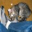

In [7]:
cat_test = image_test[0:1]
cat_test['image'].explore()

Using these models, answer the following questions.

- What is the nearest cat-labeled image in the training data to the cat image that is the first image in the test data ?

- What is the nearest dog-labeled image in the training data to the cat image that is the first image in the test data?

In [8]:
dog_model.query(cat_test, verbose=False)

query_label,reference_label,distance,rank
0,16976,37.464262878423774,1
0,13387,37.56668321685285,2
0,35867,37.60472670789396,3
0,44603,37.70655851529755,4
0,6094,38.511325490739715,5


In [9]:
cat_model.query(cat_test, verbose=False)

query_label,reference_label,distance,rank
0,16289,34.62371920804245,1
0,45646,36.00687992842462,2
0,32139,36.52008134363789,3
0,25713,36.754850252057054,4
0,331,36.87312281675268,5


# Task 3: Try a simple example of nearest-neighbors classification

When you queried the nearest neighbors model, the distance column in the Task 2 showed the computed distance between the input and each of the retrieved neighbors. In this task, you will use these distances for classification, using a nearest-neighbors classifier.

- For the first image in the test data (image_test[0:1]), compute the mean distance between this image at its five nearest neighbors that are labeled ‘cat’ in the training data (similar to what you did in the previous question).

In [10]:
cat_model.query(cat_test, verbose=False)['distance'].mean()

36.15573070978294

- For the first image in the test data (image_test[0:1]), compute the mean distance between this image at its five nearest neighbors that are labeled ‘dog’ in the training data (similar to what you did in the previous question).

In [11]:
dog_model.query(cat_test, verbose=False)['distance'].mean()

37.77071136184157

# Task 4: Compute nearest neighbors accuracy

A nearest neighbor classifier predicts the label of a point as the most common label of its nearest neighbors. In this task, you will measure the accuracy of a 1-nearest-neighbor classifier, i.e., predict the output as the label of the nearest neighbor in the training data. Although there are simpler ways of computing this result, this way introduces you to additional concepts in nearest neighbors and SFrames, which will be useful in your future machine learning education.

Use the four nearest neighbors models you trained previously on the training data, the dog, cat, automobile, and bird models.

Just as you split the training data on label, you will now use the same procedure to split the test data on the cat, dog, automobile, and bird labels. Name the resulting SFrame data structures:

image_test_cat, image_test_dog, image_test_bird, image_test_automobile

In [12]:
image_test_cat = image_test.filter_by('cat', 'label')
image_test_dog = image_test.filter_by('dog', 'label')
image_test_bird = image_test.filter_by('bird', 'label')
image_test_car = image_test.filter_by('car', 'label')

Next you'll find nearest neighbors in the training set for each part of the test set

Thus far you queried the nearest neighbors models with a single image as the input, but you can actually query with a whole set of data. The query will find the nearest neighbors for each data point. Note that the input index is stored in the query_labelcolumn of the resulting SFrame.

Using this knowledge find the closest neighbor to the dog test data using each of the trained models. For example, this code:

dog_cat_neighbors = cat_model.query(image_test_dog, k=1)

finds one neighbor (i.e., k=1) to the dog test images (image_test_dog) in the cat portion of the training data.

Next, follow the same procedure for the other dog combinations: dog-automobile, dog-bird, and dog-dog.

Create an SFrame with the distances from the dog test examples to the respective nearest neighbors in each class in the training data.

The distance column in dog_cat_neighbors contains the distance between each dog-labeled image in the test set and its nearest cat-labeled image in the training set. The question to answer is: How many of the test set dog images are closer to a dog in the training set than to a cat, automobile, or bird?

In [13]:
dog_cat_neighbors = cat_model.query(image_test_dog, k=1, verbose=False)
dog_car_neighbors = car_model.query(image_test_dog, k=1, verbose=False)
dog_bird_neighbors = bird_model.query(image_test_dog, k=1, verbose=False)
dog_dog_neighbors = dog_model.query(image_test_dog, k=1, verbose=False)

In [14]:
dog_distances = tc.SFrame({
    'dog-cat' : dog_cat_neighbors['distance'],
    'dog-car' : dog_car_neighbors['distance'],
    'dog-bird' : dog_bird_neighbors['distance'],
    'dog-dog' : dog_dog_neighbors['distance'],
})

In [22]:
def is_dog_correct(row):
    return (row['dog-dog'] < row['dog-cat'] 
            and row['dog-dog'] < row['dog-car']
            and row['dog-dog'] < row['dog-bird'])

dog_distances.apply(is_dog_correct).sum()

678

# Computing summary statistics of the data
Sketch summaries are techniques for computing summary statistics of data very quickly.  In Turi Create, SArrays include a method: SArrays.summary() which computes such summary statistics.  Using the training data, compute the summary of the ‘label’ column and interpret the results.  What’s the least common category in the training data?

In [17]:
image_train['label'].summary()


+------------------+-------+----------+
|       item       | value | is exact |
+------------------+-------+----------+
|      Length      |  2005 |   Yes    |
| # Missing Values |   0   |   Yes    |
| # unique values  |   4   |    No    |
+------------------+-------+----------+

Most frequent items:
+------------+-------+
|   value    | count |
+------------+-------+
|    cat     |  509  |
|    dog     |  509  |
| automobile |  509  |
|    bird    |  478  |
+------------+-------+


### Nearest 'cat' labeled image in the training data to the image_test[0:1]

,SArray
0,

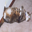

In [30]:
nearest_cat_id = cat_model.query(cat_test, k=1, verbose=False)['reference_label'][0]
image_train[image_train['id'] == nearest_cat_id]['image'].explore()

### Nearest 'dog' labeled image in the training data to the image_test[0:1]

,SArray
0,

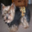

In [31]:
nearest_dog_id = dog_model.query(cat_test, k=1, verbose=False)['reference_label'][0]
image_train[image_train['id'] == nearest_dog_id]['image'].explore()

### Accuracy of 1-nearest neighbor classifier at classifying 'dog' images

In [34]:
678 / 1000 * 100

67.80000000000001